## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [304]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [305]:
#Здесь путь указан по моему, так как файл лежит в папке с ноутбуком
data = pd.read_csv('ab_data_tourist.csv') 
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


* Признаки и описание
* user_id - идентификатор пользователя, зашедшего на сайт
* date - дата захода
* group - группа теста (контрольная — А или тестовая — B)
* purchase - признак покупки: совершил ли пользователь покупку тура (1 — да, 0 — нет)
* price - цена купленного тура (если покупка не состоялась, цена равна 0)

## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [306]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


Столбец date имеет тип данных 'object'

## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [307]:
data['date'] = pd.to_datetime(data['date'])
data_A = data[data['group'] == 'A']
data_B = data[data['group'] == 'B']

In [308]:
display(f"Для группы A период тестирования составил с {data_A['date'].min()} до {data_A['date'].max()}!")
display(f"Для группы B период тестирования составил с {data_B['date'].min()} до {data_B['date'].max()}!")

'Для группы A период тестирования составил с 2021-01-02 00:00:00 до 2021-01-24 00:00:00!'

'Для группы B период тестирования составил с 2021-01-02 00:00:00 до 2021-01-24 00:00:00!'

На основании полученных периодов времени можно сделать вывод, что тестирование проводилось с 2021-01-02 по 2021-01-24 для обеих групп.

## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [309]:
# Количеством посещений сайта будет являться количество строк в данных.
display(f"Для группы A количество посещений равно: {data_A.shape[0]}.")
display(f"Для группы B количество посещений равно: {data_B.shape[0]}.")

# Суммарным количеством покупок будет являться число событий purchase равных 1.
display(f"Для группы A суммарное количество покупок равно: {data_A['purchase'].sum()}.")
display(f"Для группы B суммарное количество покупок равно: {data_B['purchase'].sum()}.")

# Суммой всех покупок будет являться сумма всех значений price.
display(f"Для группы A сумма всех покупок равна: {data_A['price'].sum()/1e6} млн. руб.")
display(f"Для группы B сумма всех покупок равна: {data_B['price'].sum()/1e6} млн. руб.")

'Для группы A количество посещений равно: 147202.'

'Для группы B количество посещений равно: 147276.'

'Для группы A суммарное количество покупок равно: 17723.'

'Для группы B суммарное количество покупок равно: 17514.'

'Для группы A сумма всех покупок равна: 1436.26 млн. руб.'

'Для группы B сумма всех покупок равна: 1554.1 млн. руб.'

## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [310]:
# Создадим множества и произведем их пересечение
users_A = set(data_A['user_id'])
users_B = set(data_B['user_id'])
users_A_and_B = users_A.intersection(users_B) 
display(f"Число пользователей, попавших в обе тестовые группы: {len(users_A_and_B)}")

'Число пользователей, попавших в обе тестовые группы: 1895'

Получается, что 1895 пользователей оказались в группах A и B. С помощью полученного множества мы сможем избавиться от таких данных.

## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [311]:
updated_data = data[data['user_id'].apply(lambda x: x not in users_A_and_B)]

Где users_A_and_B - множество пересечений пользователей групп А и B.

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

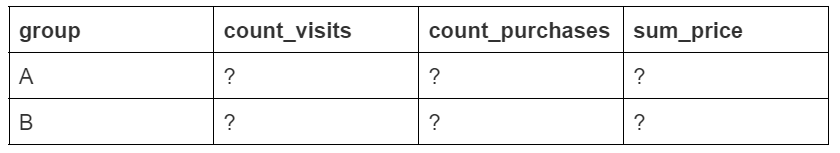
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?


In [312]:
#Создадим пустой DataFrame и заполним его признаки нужными данными
data_A_B = pd.DataFrame()

#количество посещений
data_A_B['count_visits'] = updated_data.groupby('group')['group'].count()
#количество совершенных покупок
data_A_B['count_purchase'] = updated_data.groupby('group')['purchase'].sum()
#сумма покупок
data_A_B['sum_price'] = updated_data.groupby('group')['price'].sum()

data_A_B.head()

,count_visits,count_purchase,sum_price
group,,,
A,145307,17487,1417780000
B,145381,17290,1533010000


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

### *Так как количество посещений отличаются всего на 74 шт, при выборке порядка 145000, можно смело заявлять, что количества посещений сопоставимы.*

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [313]:
data_A_B['conversion'] = round((data_A_B['count_purchase']/data_A_B['count_visits'])*100,2)
data_A_B['mean_check'] = round(data_A_B['sum_price']/data_A_B['count_purchase'])
data_A_B.head()

,count_visits,count_purchase,sum_price,conversion,mean_check
group,,,,,
A,145307,17487,1417780000,12.03,81076.0
B,145381,17290,1533010000,11.89,88665.0


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

### *Анализируя полученную таблицу, делаем вывод, что конверсия в группе A выше (12.03>11.89), но в то же время, в группе B больше средний чек (88665>81076). Для принятия или отвержения модели B нужны дальнейшие исследования.*

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [314]:
#Построим сводную таблицу

price_A_B = updated_data.pivot_table(
    values='purchase',  #количество покупок будут значениями признаков
    index='price',      #цены на туры будут индексами
    columns='group',    #признаками будут группы A и B
    aggfunc='count',
)
price_A_B

group,A,B
price,,
0,127820,128091
10000,5182,5201
60000,5271,1730
100000,1832,5227
150000,3478,3438
200000,1724,1694


Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

<AxesSubplot:xlabel='group', ylabel='price'>

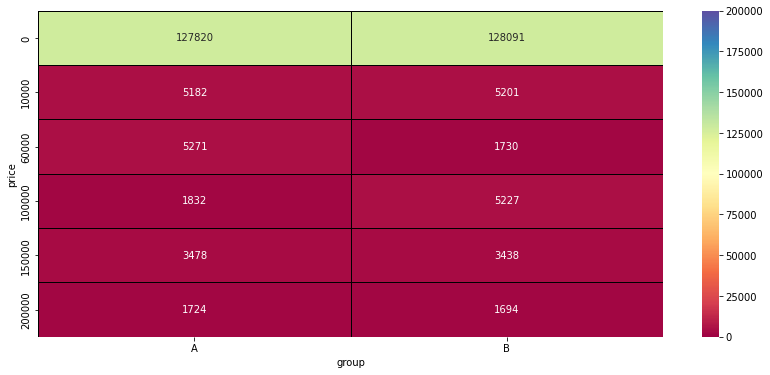

In [315]:
#Построим теплолвую карту
plt.figure(figsize=(14,6))
sns.heatmap(price_A_B, annot=True, vmin=0, vmax=200000, cmap='Spectral', linewidth=0.5, linecolor='black', fmt='1g')

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

### *Покупательская способность в группах A и B отличается следующим образом:*

* Санкт-Петербург — 10000 рублей -> A > B
* Турция — 60000 рублей -> A > B
* Таиланд — 100000 рублей -> A < B
* Камчатка — 150000 рублей -> A > B
* Мальдивы — 200000 рублей -> A > B

*При этом стоит отметить, что для Санкт-Петербурга, Камчатки и Мальдив отличия не такие большие, как для Турции (у группы A пользовалась большей популярностью), так и для Тайланда (у группы B пользовался большей популярностью).*

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [316]:
# Создадим сводную таблицу с данными по дням
date_A_B = updated_data.groupby(['date','group'])['purchase','price'].agg(
    ['count','sum']
)
date_A_B.head()

C:\Users\mish9\AppData\Local\Temp/ipykernel_2572/2014932658.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  date_A_B = updated_data.groupby(['date','group'])['purchase','price'].agg(


purchase      price          
                    count  sum count       sum
date       group                              
2021-01-02 A         2854  359  2854  29410000
           B         2861  345  2861  29660000
2021-01-03 A         6596  748  6596  62000000
           B         6619  754  6619  65960000
2021-01-04 A         6566  799  6566  64250000

In [317]:
#Просмторим признаки полученной таблицы
date_A_B.columns

MultiIndex([('purchase', 'count'),
            ('purchase',   'sum'),
            (   'price', 'count'),
            (   'price',   'sum')],
           )

In [318]:
# Построим интересующую нас таблицу. Для этого создадим пустой DataFrame и заполним его интересующими данными:
# количество посещений страницы, количество покупок и сумма покупок, ежедневная конверсия, ежедневный средний чек
# распределенные по группе тестирования
days_A_B = pd.DataFrame()
# Количество посещений (можно посчитать через количество совершенных и не совершенных покупок, 
# так как в count значения 0 тоже учитываются)
days_A_B['count_visit'] = date_A_B[('purchase', 'count')]

# Количество покупок (можно посчитать через сумму покупок, так как в sum значения 0 не учитываются)
days_A_B['count_purchase'] = date_A_B[('purchase', 'sum')]

# Сумма покупок (сумма значений признака price)
days_A_B['sum_price'] = date_A_B[('price', 'sum')]

# Ежедневная конверсия (сумма 1 purchase (совешенных покупок) 
# деленое на количество совершенных и не совершенных покупок)
days_A_B['conversion'] = round(date_A_B[('purchase',   'sum')]/date_A_B[('purchase', 'count')]*100, 2)

# Ежедневны средний чек (сумма покупок деленое на количество совершенных покупок)
days_A_B['mean_check'] = round(date_A_B[('price',   'sum')]/date_A_B[('purchase',   'sum')])
days_A_B.head()

count_visit  count_purchase  sum_price  conversion  \
date       group                                                       
2021-01-02 A             2854             359   29410000       12.58   
           B             2861             345   29660000       12.06   
2021-01-03 A             6596             748   62000000       11.34   
           B             6619             754   65960000       11.39   
2021-01-04 A             6566             799   64250000       12.17   

                  mean_check  
date       group              
2021-01-02 A         81922.0  
           B         85971.0  
2021-01-03 A         82888.0  
           B         87480.0  
2021-01-04 A         80413.0

* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [319]:
#Рассмотрим 3 января 2021 года.
days_A_B[['conversion','mean_check']].loc['2021-01-03']



conversion  mean_check
date       group                        
2021-01-03 A           11.34     82888.0
           B           11.39     87480.0

### *Можем сделать вывод, что конверсия для групп равна:*
* A -> 11.34%;
* B -> 11.39%.

### *А средний чек:*
* A -> 82888 руб.
* B -> 87480 руб.


## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [320]:
# Вычислим куммулятивное количество посещений страницы
days_A_B.loc[:,'cum_count_visit'] = days_A_B['count_visit'].cumsum()

# Вычислим куммулятивное количество покупок
days_A_B.loc[:,'cum_count_purchase'] = days_A_B['count_purchase'].cumsum()

# Вычислим куммулятивную сумму покупок
days_A_B.loc[:,'cum_sum_price'] = days_A_B['sum_price'].cumsum()

# На основе полученных куммулятивных показателей вычислим:
# куммулятивную конверсию
days_A_B['cum_conversion'] = round(days_A_B['cum_count_purchase']/days_A_B['cum_count_visit']*100, 2)

# Куммулятивный средний чек
days_A_B['cum_mean_check'] = round(days_A_B['cum_sum_price']/days_A_B['cum_count_purchase'])


days_A_B.head(5)


count_visit  count_purchase  sum_price  conversion  \
date       group                                                       
2021-01-02 A             2854             359   29410000       12.58   
           B             2861             345   29660000       12.06   
2021-01-03 A             6596             748   62000000       11.34   
           B             6619             754   65960000       11.39   
2021-01-04 A             6566             799   64250000       12.17   

                  mean_check  cum_count_visit  cum_count_purchase  \
date       group                                                    
2021-01-02 A         81922.0             2854                 359   
           B         85971.0             5715                 704   
2021-01-03 A         82888.0            12311                1452   
           B         87480.0            18930                2206   
2021-01-04 A         80413.0            25496                3005   

                  cum_sum_price  cum_conversion  cum_mean_check  
date       group                                                 
2021-01-02 A           29410000           12.58         81922.0  
           B           59070000           12.32         83906.0  
2021-01-03 A          121070000           11.79         83382.0  
           B          187030000           11.65         84782.0  
2021-01-04 A          251280000           11.79         83621.0

Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

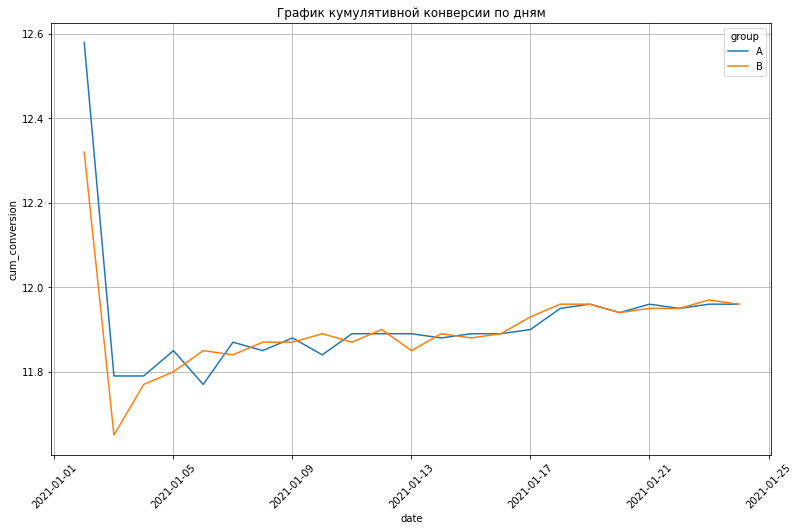

In [321]:
# Создаём фигуру размером 10x6
fig = plt.figure(figsize=(10, 6))
# Добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# Строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='cum_conversion', data=days_A_B, hue='group', ax=ax)
# Задаём подпись к графику
ax.set_title('График кумулятивной конверсии по дням')
# Задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# Задаём отображение сетки
ax.grid(True);

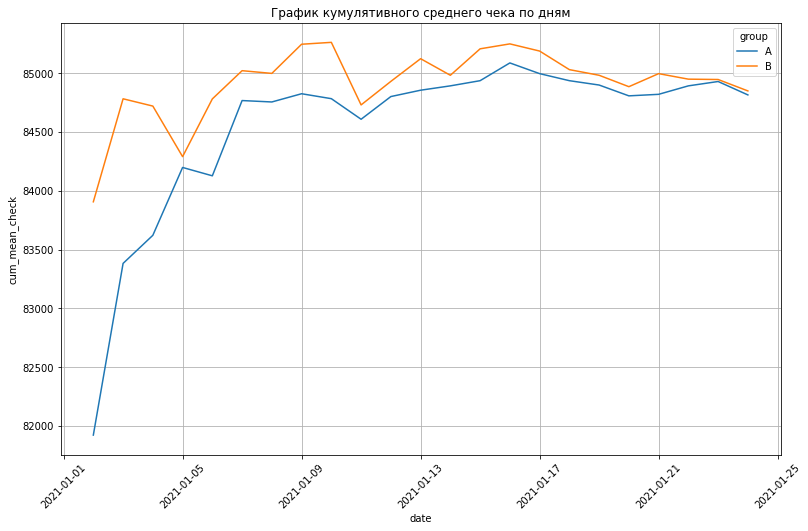

In [322]:
# Создаём фигуру размером 10x6
fig = plt.figure(figsize=(10, 6))
# Добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# Строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='cum_mean_check', data=days_A_B, hue='group', ax=ax)
# Задаём подпись к графику
ax.set_title('График кумулятивного среднего чека по дням')
# Задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# Задаём отображение сетки
ax.grid(True);

### *Проанализировав графики понимаем, что куммулятивная конверсия по дням стабилизировалась, но для куммулятивного среднего чека было бы желательно продолжить эксперимент, для лучшей стабилизации.*

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [323]:
updated_data.head(5)

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


In [324]:
converted_piv= updated_data.groupby('group')['purchase'].agg(
    ['sum', 'count']
)
display(converted_piv)

,sum,count
group,,
A,17487,145307
B,17290,145381


In [325]:
# нулевая и альтернативная гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А выше, чем конверсия в группе B'
alpha = 0.05 # уровень значимости

# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=converted_piv['sum'], #число "успехов"
    nobs=converted_piv['count'], #общее число наблюдений
    alternative='larger',
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value:  0.12
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

### Так как конверсии в группах равны с уровнем значимости 0.05, можно сделать вывод, что одинаково эффективны оба варианта посадочной страницы.

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [326]:
# Фильтруем данные группы А
data_A = updated_data[updated_data['group'] == 'A']
# Фильтруем данные группы B
data_B = updated_data[updated_data['group'] == 'B']


def proportions_conf_interval(n, x_p, gamma=0.95):   
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)


conf_interval_a = proportions_conf_interval(
    n=data_A['user_id'].count(), # размер выборки
    x_p=data_A['purchase'].mean() # выборочная пропорция
    )

conf_interval_b = proportions_conf_interval(
    n=data_B['user_id'].count(), # размер выборки
    x_p=data_B['purchase'].mean() # выборочная пропорция
    )
print('Доверительный интервал для конверсии группы А: {}'.format(conf_interval_a))
print('Доверительный интервал для конверсии группы B: {}'.format(conf_interval_b))


Доверительный интервал для конверсии группы А: (11.87, 12.2)
Доверительный интервал для конверсии группы B: (11.73, 12.06)


In [327]:
def diff_proportions_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)

# размеры выборок групп А и B
n = [data_A['user_id'].count(), data_B['user_id'].count()]
# выборочная пропорция групп A и B
xp = [data_A['purchase'].mean(), data_B['purchase'].mean()]
# строим доверительный интервал для разности конверсий
diff_inverval = diff_proportions_conf_interval(n, xp)
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))

Доверительный интервал для разности конверсий: (-0.38, 0.09)


Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

### Так как доверительные интервалы конверсий охватывают общую область (11.87, 12.06), а доверительный интервал разницы конверсий проходит включает в себя точку 0 (-0.38, 0.09) - можно сделать вывод, что статистической разницы в конверсии между вариантами А и B не существует, то есть они являются равнозначными по данной метрике.

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

In [256]:
days_A_B.head()

count_visit  count_purchase  sum_price  conversion  \
date       group                                                       
2021-01-02 A             2854             359   29410000       12.58   
           B             2861             345   29660000       12.06   
2021-01-03 A             6596             748   62000000       11.34   
           B             6619             754   65960000       11.39   
2021-01-04 A             6566             799   64250000       12.17   

                  mean_check  cum_count_visit  cum_count_purchase  \
date       group                                                    
2021-01-02 A         81922.0             2854                 359   
           B         85971.0             5715                 704   
2021-01-03 A         82888.0            12311                1452   
           B         87480.0            18930                2206   
2021-01-04 A         80413.0            25496                3005   

                  cum_sum_price  cum_conversion  cum_mean_check  
date       group                                                 
2021-01-02 A           29410000           12.58         81922.0  
           B           59070000           12.32         83906.0  
2021-01-03 A          121070000           11.79         83382.0  
           B          187030000           11.65         84782.0  
2021-01-04 A          251280000           11.79         83621.0

Для начала посмотрим на график распределения ежедневного среднего чека по группам.

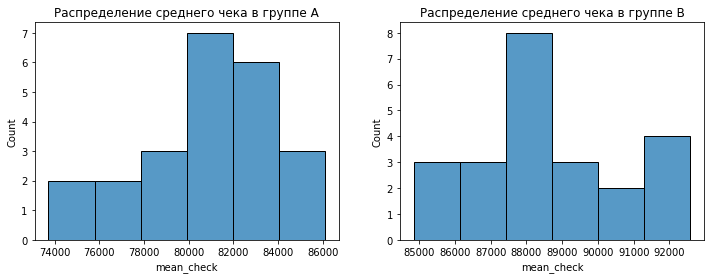

In [341]:
#создаём 2 графика размером 12x4
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
#строим гистограмму для времени на сайте в каждой группе
sns.histplot(x='mean_check', data=days_A_B.xs('A', level='group'), ax=axes[0])
sns.histplot(x='mean_check', data=days_A_B.xs('B', level='group'), ax=axes[1])
#задаём названия графикам
axes[0].set_title('Распределение среднего чека в группе А');
axes[1].set_title('Распределение среднего чека в группе B');

Распрделения напоминают нормальные. Проверим гипотезу о нормальности обоих распределений с помощью критерия Шапиро-Уилка.

In [347]:
from scipy.stats import shapiro
# нулевая и альтернативная гипотезы
H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'
alpha = 0.05 # уровень значимости
# вычисляем результат теста Шапиро-Уилка для выборок
shapiro_result_a = shapiro(days_A_B.xs('A', level='group')['mean_check'])
shapiro_result_b = shapiro(days_A_B.xs('B', level='group')['mean_check'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))
# сравниваем полученное p-value с уровнем значимости
if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))
 
# p-value группы А 0.43
# p-value группы B 0.12
# Принимаем нулевую гипотезу. Распределения в обеих группах нормальные

p-value группы А 0.25
p-value группы B 0.09
Принимаем нулевую гипотезу. Распределения в обеих группах нормальные


## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [348]:
from scipy.stats import ttest_ind
# нулевая и альтернативная гипотезы
H0 = 'Ежедневные средние чеки в группах А и B равны.' 
H1 = 'Ежедневный средний чек в группе А меньше чем в группе B.'
alpha = 0.05 #уровень значимости
#вычисляем результат T-теста для выборок
results = ttest_ind(
    a=days_A_B.xs('A', level='group')['mean_check'],
    b=days_A_B.xs('B', level='group')['mean_check'], 
    alternative='less'
)
print('p-value:', round(results.pvalue, 2))
 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value: 0.0
Отвергаем нулевую гипотезу. Ежедневные средние чеки в группах А и B равны.
Альтернативная гипотеза. H1: Ежедневный средний чек в группе А меньше чем в группе B.


 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

### По полученным данным, делаем вывод, что ежедневный средний чек в группе B больше, чем в группе A.

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [354]:
days_A_B.xs('A', level='group').head(3)

,count_visit,count_purchase,sum_price,conversion,mean_check,cum_count_visit,cum_count_purchase,cum_sum_price,cum_conversion,cum_mean_check
date,,,,,,,,,,
2021-01-02,2854,359,29410000,12.58,81922.0,2854,359,29410000,12.58,81922.0
2021-01-03,6596,748,62000000,11.34,82888.0,12311,1452,121070000,11.79,83382.0
2021-01-04,6566,799,64250000,12.17,80413.0,25496,3005,251280000,11.79,83621.0


In [438]:
# Фильтруем данные группы А
data_A = updated_data[updated_data['group'] == 'A']
# Фильтруем данные группы B
data_B = updated_data[updated_data['group'] == 'B']


def mean_conf_interval(n, x_p, x_std, gamma=0.95):   
    alpha = 1 - gamma # уровень значимости
    t_crit = -t.ppf(alpha/2, (n-1)) # t-критическое
    eps = t_crit * x_std/(n ** 0.5) # погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound), round(upper_bound)
 
conf_interval_a = mean_conf_interval(
    n=days_A_B.xs('A', level='group')['mean_check'].count(), # размер выборки
    x_p=days_A_B.xs('A', level='group')['mean_check'].mean(), # выборочная пропорция
    x_std=(days_A_B.xs('A', level='group')['mean_check']).std()
    )

conf_interval_b = mean_conf_interval(
    n=days_A_B.xs('B', level='group')['mean_check'].count(), # размер выборки
    x_p=days_A_B.xs('B', level='group')['mean_check'].mean(), # выборочная пропорция
    x_std=(days_A_B.xs('B', level='group')['mean_check']).std()
    )
print('Доверительный интервал для среднего чека группы А: {}'.format(conf_interval_a))
print('Доверительный интервал для среднего чека группы B: {}'.format(conf_interval_b))

Доверительный интервал для среднего чека группы А: (79630, 82308)
Доверительный интервал для среднего чека группы B: (87626, 89526)


Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

### По полученным интервалам становится ясно, что в группе B средний чек лежит в больших пределах (87626, 89526), чем в группе А (79630, 82308). Это значит, что вариант "B" посадочной страницы будет приносить больше дохода.

## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 

# Подведем итог. 
### В ходе исследования было выявлено, что конверсия в группа A и B не имеет статистически значимых отличий - вариант посадочной страницы "B" не окажет существенного влияния на повышение показатели конверсии.
### Однако, по опказателю среднего чека, вариант посадочной страницы "B" выигрывает, так как его доверительный интервал лежит в больших пределах (87626, 89526) > (79630, 82308) и превышает вариант "A" на 7000-8000 рублей. 
По предварительным оценкам, переход к варианту B будет приносить увеличенный на 7000-8000 ежедневный доход, что за год составляет 2,5-3 млн. рублей.